# Predictive Analytics in Horse Racing using Gradient Boosting and AdaBoost

### *Group Members*

- Harrye Fredericksen (23020603)
- Kobe Spring (24004428)
- Lagi Rabo (04225368)
- Jason Wing (16339768)

## Introduction


Horse racing 

### ***Imports***

In [101]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, make_scorer
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier


### ***Dataset***



In [8]:
#Harrye please show the code that was used to obtain this data and place in any cleaning code that was performed - make sure to have it documented down here as EXTENSIVELY as possible please.

In [9]:
cleaned_df = pd.read_csv("cleaned_data_v1.csv")
cleaned_df.head(10)

,course_id,race_id,dist_m,going,ran,pos,draw,ovr_btn,btn,horse_id,...,has_blinkers,has_tongue_tie,has_visor,has_cheekpieces,has_eye_hood,has_eyecover,has_eyeshield,has_hood,no_headgear,first_time_equipment
0,297,308856,3200,5.0,22,1,13.0,0.00,0.00,548204,...,0,0,0,0,0,0,0,0,0,0
1,297,308856,3200,5.0,22,2,15.0,0.75,0.75,518856,...,0,0,0,0,0,0,0,0,0,0
2,297,308856,3200,5.0,22,3,11.0,6.75,6.00,447498,...,0,0,0,0,0,0,0,0,0,0
3,297,308856,3200,5.0,22,4,19.0,7.50,0.75,458259,...,1,0,0,0,0,0,0,0,0,0
4,297,308856,3200,5.0,22,5,10.0,7.75,0.30,554624,...,0,0,0,0,0,0,0,0,0,0
5,297,308856,3200,5.0,22,6,23.0,7.75,0.05,554625,...,0,0,0,0,0,0,0,0,0,0
6,297,308856,3200,5.0,22,7,7.0,8.50,0.75,519815,...,1,0,0,0,0,0,0,0,0,0
7,297,308856,3200,5.0,22,8,21.0,8.75,0.20,504666,...,1,0,0,0,0,0,0,0,0,0
8,297,308856,3200,5.0,22,9,17.0,10.25,1.50,529388,...,0,0,0,0,0,0,0,0,0,0
9,297,308856,3200,5.0,22,10,3.0,12.00,1.75,514914,...,0,0,0,0,0,0,0,0,0,0


### Harrye

In [11]:
#Under your name enter in the ML code that you have created - ADDITIONALLY PLEASE write a relatively extensive paragraph AT minimum 5-6 sentences long that outlines what your ML question is looking at and why etc. I recommend everyone mnake their own initial copy of the df please.

### Kobe


In [13]:
#notes: discovered that there we a few very prolific sires so therefore had to log transform. one sire had 1000< foals - whilst alot have less <10

In [14]:
kns_df = cleaned_df.copy()
kns_df['top3'] = (kns_df['pos'] <= 3).astype(int)

kns_train_df, kns_test_df = train_test_split(
    kns_df, test_size=0.2, stratify=kns_df['top3'], random_state=42
)

kns_min_runners = 3

kns_sire_stats = (
    kns_train_df.groupby('sire_id')['top3']
    .agg(['mean', 'count'])
    .rename(columns={'mean': 'sire_top3_rate', 'count': 'sire_runners'})
)
kns_sire_stats = kns_sire_stats[kns_sire_stats['sire_runners'] >= kns_min_runners]

kns_dam_stats = (
    kns_train_df.groupby('dam_id')['top3']
    .agg(['mean', 'count'])
    .rename(columns={'mean': 'dam_top3_rate', 'count': 'dam_runners'})
)
kns_dam_stats = kns_dam_stats[kns_dam_stats['dam_runners'] >= kns_min_runners]

kns_train_df = (
    kns_train_df
    .merge(kns_sire_stats[['sire_top3_rate','sire_runners']], on='sire_id', how='left')
    .merge(kns_dam_stats[['dam_top3_rate','dam_runners']], on='dam_id', how='left')
)

kns_test_df = (
    kns_test_df
    .merge(kns_sire_stats[['sire_top3_rate','sire_runners']], on='sire_id', how='left')
    .merge(kns_dam_stats[['dam_top3_rate','dam_runners']], on='dam_id', how='left')
)

for kns_col in ['sire_top3_rate','dam_top3_rate','sire_runners','dam_runners']:
    kns_train_df[kns_col] = kns_train_df[kns_col].fillna(0)
    kns_test_df[kns_col]  = kns_test_df[kns_col].fillna(0)

In [15]:
for kns_df_tmp in [kns_train_df, kns_test_df]:
    kns_df_tmp['sire_runners_log'] = np.log1p(kns_df_tmp['sire_runners'])

kns_base_feats = ['dist_m','going','ran','age','lbs','has_blinkers','has_tongue_tie']

kns_lineage_feats = kns_base_feats + ['sire_top3_rate','dam_top3_rate','sire_runners_log','dam_runners']

kns_categorical_feats = ['has_blinkers', 'has_tongue_tie']

kns_base_feats    = [f for f in kns_base_feats if f in kns_train_df.columns]
kns_lineage_feats = [f for f in kns_lineage_feats if f in kns_train_df.columns]

kns_X_train_b, kns_y_train_b = kns_train_df[kns_base_feats],    kns_train_df['top3']
kns_X_test_b,  kns_y_test_b  = kns_test_df[kns_base_feats],     kns_test_df['top3']

kns_X_train_l, kns_y_train_l = kns_train_df[kns_lineage_feats], kns_train_df['top3']
kns_X_test_l,  kns_y_test_l  = kns_test_df[kns_lineage_feats],  kns_test_df['top3']


In [16]:
def run_lightgbm(X_train, y_train, X_test, y_test, feature_label):

    print(f"\n*** Running LightGBM ({feature_label.upper()} FEATURES) ***\n")

    scale = (y_train == 0).sum() / (y_train == 1).sum()
    print(f"Scale_pos_weight = {scale:.2f}\n")

    n_estimators  = [100, 200, 300, 400, 500]
    learning_rate = [0.005, 0.01, 0.05, 0.1]
    max_depth     = [-1, 3, 5]

    best_auc  = 0
    best_combo = None

    for n in n_estimators:
        for lr in learning_rate:
            for md in max_depth:

                model = LGBMClassifier(
                    n_estimators=n,
                    learning_rate=lr,
                    max_depth=md,
                    scale_pos_weight=scale,
                    random_state=42,
                    verbose=-1
                )

                model.fit(
                    X_train, y_train,
                    eval_set=[(X_test, y_test)],
                    eval_metric="auc",
                    callbacks=[lgb.early_stopping(50)],
                )

                preds_proba = model.predict_proba(X_test)[:, 1]
                preds_label = (preds_proba >= 0.25).astype(int)

                acc = accuracy_score(y_test, preds_label)
                f1  = f1_score(y_test, preds_label)
                auc = roc_auc_score(y_test, preds_proba)

              #  print(f"Params (n_estimators={n}, learning_rate={lr}, max_depth={md}): "
                 #     f"AUC={auc:.4f}, ACC={acc:.4f}, F1={f1:.4f}")

                if auc > best_auc:
                    best_auc  = auc
                    best_combo = (n, lr, md)

    print(f"\nBest LightGBM ({feature_label}) model: AUC={best_auc:.4f} with params {best_combo}\n")
    return best_auc, best_combo

In [17]:
base_auc, base_params = run_lightgbm(
    kns_X_train_b, kns_y_train_b, kns_X_test_b, kns_y_test_b, feature_label="base"
)

lineage_auc, lineage_params = run_lightgbm(
    kns_X_train_l, kns_y_train_l, kns_X_test_l, kns_y_test_l, feature_label="lineage"
)

print(f"\nAUC (base): {base_auc:.4f}")
print(f"AUC (lineage): {lineage_auc:.4f}")
print(f"Improvement: {lineage_auc - base_auc:.4f}")


*** Running LightGBM (BASE FEATURES) ***

Scale_pos_weight = 2.84

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.615437	valid_0's binary_logloss: 0.570396
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.610697	valid_0's binary_logloss: 0.571095
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.615085	valid_0's binary_logloss: 0.570545
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's auc: 0.615441	valid_0's binary_logloss: 0.570385
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's auc: 0.611098	valid_0's binary_logloss: 0.571093
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's auc: 0.614973	valid_0

### Lagi

In [19]:
#Under your name enter in the ML code that you have created - ADDITIONALLY PLEASE write a relatively extensive paragraph AT minimum 5-6 sentences long that outlines what your ML question is looking at and why etc.  I recommend everyone mnake their own initial copy of the df please.

**Research Question:** What impact does the environment (weather and track conditions) and equipment impact on a racing event? Focussing on top - 3 winners. 

As a project team, my question looks to provide predictive analysis in the horse racing sector looking at how weather and track conditions impact the outcome of races


In [21]:
# unique copy of the dataframe
lr_df = cleaned_df.copy()

In [22]:
# Setting the targets for the analysis
lr_df = lr_df[lr_df['pos'].notna()].copy()
lr_df['Top3'] = (lr_df['pos'] <= 3).astype(int)

In [23]:
# Feature Engineering requirements
# Deriving the draw ratio to adjust for field size
lr_df['draw_normalized'] = (lr_df['draw'] / lr_df['ran'].replace({0:np.nan})).fillna(0)

In [24]:
# Drawing out the feature groups (environmental, physical)
lr_numeric_features = [
    'dist_m',            # race distance (m) 
    'going',             # track conditions (1 = Hard..8 - Heavy; 4.5 = Standard)
    'ran',               # field size
    'draw',              # barrier position
    'carry_wgt_pounds',  # total weight carried     
    'lbs',               # horse weight (if separate from carry_wgt_pounds)
    'age',               # horse age
]

In [25]:
# Drawing out the features (equipment)
lr_equipment_features = [
    'has_blinkers'           # horse wearing blinkers
    'has_tongue_tie'         # horse wearing tongue tie
    'has_visor'              # horse wearing visor
    'has_cheekpieces'        # horse wearing cheekpieces
    'has_eye_hood'           # horse wearing eye hood
    'has_eyecover'           # horse wearing eyecover
    'has_eyeshield'          # horse wearing eyeshield
    'has_hood'               # horse wearing wood
    'no_headgear'            # horse wearing no headgear
    'first_time_equipment'   # first time wearing any equipment
]

In [26]:
# Race restriction features/flags
lr_restriction_features = [
    'is_female_restricted',   # Race limited to fillies/mares (1 = yes, 0 = no)
    'is_male_restricted',     # Race limited to colts/geldings (1 = yes, 0 = no)
    'is_open'                 # No sex restriction (1 = yes, 0 = no)
]

In [27]:
# region surface and refining columns
lr_region_surface = [c 
                     for c in lr_df.columns
                         if c.startswith('region_') or c.startswith('surface_')]

In [28]:
# retaining only the valid columns in the lr_df
lr_feature_cols = [c 
                    for c in (lr_numeric_features + lr_equipment_features + lr_restriction_features + lr_region_surface)
                       if c in lr_df.columns]

In [29]:
# establishing the updated splits (X & y)
lr_X = lr_df[lr_feature_cols].copy()
lr_y = lr_df['Top3'].copy()

In [30]:
# Train / Test Split using train_test_split
lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_X, lr_y, test_size = 0.2, stratify = lr_y, random_state = 42)


In [31]:
# LightGBM Model

lr_lgbm_parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'colsample_bytree': 0.9,
    'subsample': 0.8,
    'subsample_freq': 5,
    'random_state': 42,
    'n_estimators': 300
    
}
lr_lgb_model = lgb.LGBMClassifier(**lr_lgbm_parameters)
lr_lgb_model.fit(lr_X_train, lr_y_train)


LGBMClassifier(colsample_bytree=0.9, learning_rate=0.05, metric='auc',
               n_estimators=300, objective='binary', random_state=42,
               subsample=0.8, subsample_freq=5)

In [32]:
# evaluation
lr_y_pred = lr_lgb_model.predict(lr_X_test)
lr_y_proba = lr_lgb_model.predict_proba(lr_X_test)[:, 1]

# print output
print("Classification Report:\n", classification_report(lr_y_test, lr_y_pred))
print(f"Accuracy: {accuracy_score(lr_y_test, lr_y_pred):.3f}")
print(f"F1-Score: {f1_score(lr_y_test, lr_y_pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(lr_y_test, lr_y_proba):.3f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.99      0.85      7414
           1       0.56      0.05      0.09      2609

    accuracy                           0.74     10023
   macro avg       0.65      0.52      0.47     10023
weighted avg       0.70      0.74      0.65     10023

Accuracy: 0.742
F1-Score: 0.088
ROC-AUC: 0.611


### Initial Evaluation Metrics

The metrics provide an insight into how well the model predicts Top-3 finishes in a horse race based solely on environmental conditions.

The LightGBM model achieved an overall accuracy of 74 % and ROC-AUC of 0.61 when predicting Top-3 finishes using only environmental and equipment factors. While the model effectively identified non-Top-3 outcomes, its low recall (5 %) for Top-3 finishes indicates difficulty detecting winners under these limited feature conditions. This suggests that pre-race environmental and physical variables alone have weak predictive power, aligning with our hypothesis that external human and genetic factors play larger roles.

Given the current model looks to be suffering from class imbalance and under-sensitive recall, there will require further exploration into more ways to re-tune the model. I will look to explores areas of Feature Engineering, Model Tuning, Hyperparameter

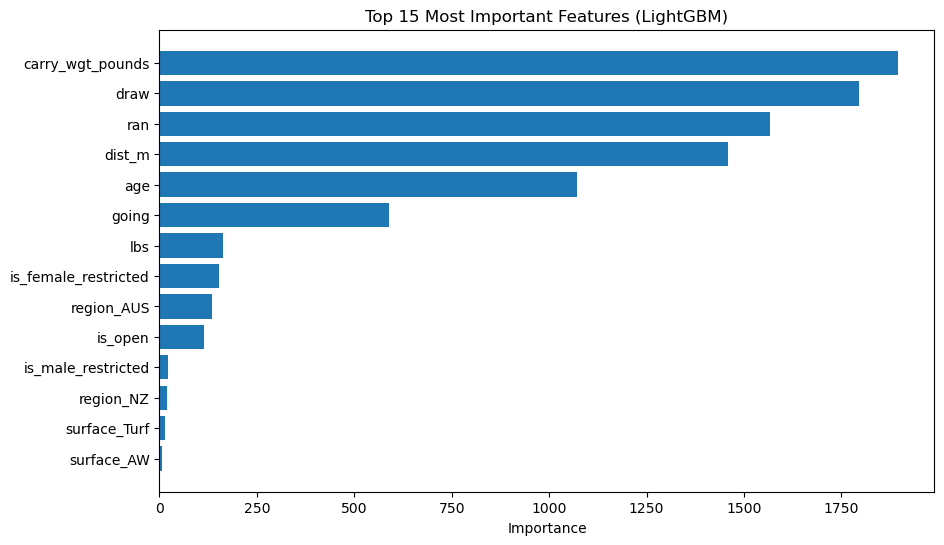

In [34]:
# Visual - Feature importance

lr_feature_importance = pd.DataFrame({
    'feature': lr_X.columns,
    'importance': lr_lgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(lr_feature_importance['feature'][:15], lr_feature_importance['importance'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Most Important Features (LightGBM)")
plt.xlabel("Importance")
plt.show()

In [35]:
# Diagnose class imbalance
lr_y_train.value_counts(normalize=True)

Top3
0    0.739667
1    0.260333
Name: proportion, dtype: float64

In [36]:
# Apply class weighting in LightGBM
lr_n_pos = lr_y_train.sum()
lr_n_neg = len(lr_y_train) - lr_n_pos
scale = lr_n_neg / lr_n_pos

print("scale_pos_weight =", scale)

scale_pos_weight = 2.841237903612149


In [37]:
# retrain the sample using scale_pos_weight formula above
# LightGBM Model

lr_lgbm_parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'colsample_bytree': 0.9,
    'subsample': 0.8,
    'subsample_freq': 5,
    'n_estimators': 300,
    'random_state': 42,
    'scale_pos_weight': scale,
    'verbose': -1    
}
lr_lgb_model = lgb.LGBMClassifier(**lr_lgbm_parameters)
lr_lgb_model.fit(lr_X_train, lr_y_train)


LGBMClassifier(colsample_bytree=0.9, learning_rate=0.05, metric='auc',
               n_estimators=300, objective='binary', random_state=42,
               scale_pos_weight=2.841237903612149, subsample=0.8,
               subsample_freq=5, verbose=-1)

In [38]:
# Cross validation and early stopping
lr_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr_auc_scores = []
for lr_train_idx, lr_val_idx in lr_kf.split(lr_X_train, lr_y_train):
    lr_X_tr, lr_X_val = lr_X_train.iloc[lr_train_idx], lr_X_train.iloc[lr_val_idx]
    lr_y_tr, lr_y_val = lr_y_train.iloc[lr_train_idx], lr_y_train.iloc[lr_val_idx]

    lr_lgb_model = lgb.LGBMClassifier(**lr_lgbm_parameters)
    callbacks =[lgb.early_stopping(stopping_rounds=30, verbose=False)]
    lr_lgb_model.fit(
        lr_X_tr, 
        lr_y_tr,
        eval_set=[(lr_X_val, lr_y_val)],
        eval_metric='auc',
    )
    lr_auc_scores.append(lr_lgb_model.best_score_['valid_0']['auc'])

print(f"Mean CV AUC: {np.mean(lr_auc_scores): 3f}")
print(f"Std CV AUC: {np.std(lr_auc_scores): 3f}")

Mean CV AUC:  0.600946
Std CV AUC:  0.004595


### Analysis 

The cross-validation results have returned a mean value of 0.60 (60%), which means that the model can distinguish the top-3 vs. non top-3 horses 60% of the time, which is better than random (0.5), however, 0.6 or 60% is still a weak discriminative power. A very small standard deviation would imply that the model is consistent in that its limited predictive ability is stable and not random. 

Overall, this result shows a stable but modest performance and a valuable finding at this stage is that, environmental and equipment variables provide limited but consisten predictive power in determinig top-3 outcomes, confirming that other dimensions (human or genetic factor) are more likely to play stronger roles.


### Next Steps

**Hyperparameter Tuning** - Further


### Jason

**Research Question:** "Do frequent trainer/jockey pairings outperform infrequent pairings?"

In the context of horse racing, a trainer and jockey need to work closely together to bring the best performance out of the horse. It is reasonable to therefore assume that ongoing relationships between jockey/trainer would equate to better performance. 

The purpose of this research question is to establish whether there is a relationship between frequent pairings and performance, and to what extent this relationship may be useful in predicting race outcomes. 

As outlined in the exploration below, I have defined a 'frequent pairing' as a jockey/trainer pairing that has worked together 10 or more times which captures approximately 6.5% of pairings.  

In [42]:
jw_df = cleaned_df.copy()

#calculating jockey/trainer pairing counts
jw_pairing_counts = (
    jw_df.groupby(['trainer_id', 'jockey_id'])
    .size()
    .reset_index(name='jw_pairing_count')
    .sort_values('jw_pairing_count', ascending=False)
)
jw_pairing_counts.head()

,trainer_id,jockey_id,jw_pairing_count
2289,13495,87112,381
2472,13677,78482,366
2245,13495,79529,335
11584,32239,85469,328
3954,15511,87112,317


In [43]:
#exploring stats to consider how to define 'frequent pairing' 
jw_pairing_counts['jw_pairing_count'].describe()

count    13678.000000
mean         3.663840
std         11.344771
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        381.000000
Name: jw_pairing_count, dtype: float64

In [44]:
jw_pairing_counts['jw_pairing_count'].quantile([0.5, 0.75, 0.9, 0.95, 0.99])

0.50     1.0
0.75     3.0
0.90     7.0
0.95    12.0
0.99    40.0
Name: jw_pairing_count, dtype: float64

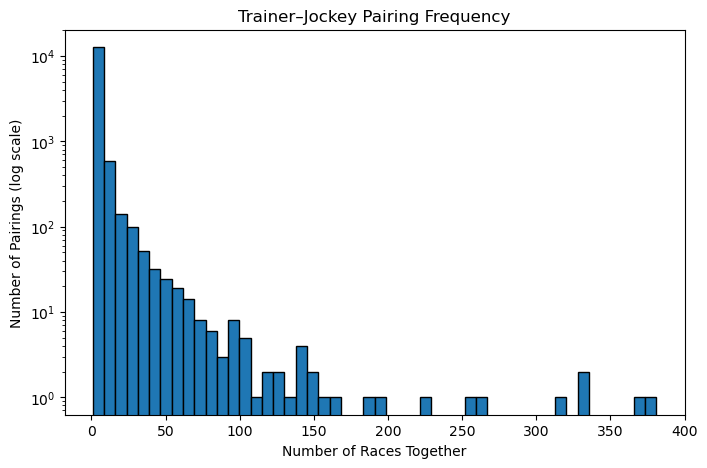

In [45]:
plt.figure(figsize=(8,5))
plt.hist(jw_pairing_counts['jw_pairing_count'], bins=50, edgecolor='black', log=True)
plt.title('Trainer–Jockey Pairing Frequency')
plt.xlabel('Number of Races Together')
plt.ylabel('Number of Pairings (log scale)')
plt.show()

Based on the above analysis, I have defined jockey/trainer 'frequent pairing' as any pair that has worked together 10 or more times. For the sake of our exploration, anything less than this will be considered infrequent/adhoc.

In [47]:
#creating binary value for frequent pairings
jw_pairing_counts['jw_is_frequent_pairing'] = np.where(
    jw_pairing_counts['jw_pairing_count'] >= 10, 'Yes', 'No'
)

# count each group 
jw_pairing_counts['jw_is_frequent_pairing'].value_counts()

jw_is_frequent_pairing
No     12793
Yes      885
Name: count, dtype: int64

In [48]:
#calculating win rates per pairing
jw_pairing_stats = (
    jw_df.groupby(['trainer_id', 'jockey_id'])
    .agg(
        jw_total_races=('race_id', 'count'),
        jw_wins=('pos', lambda x: (x == 1).sum())
    )
    .reset_index()
)

# win rate
jw_pairing_stats['jw_pairing_win_rate'] = jw_pairing_stats['jw_wins'] / jw_pairing_stats['jw_total_races']

# merge with pairing counts
jw_pairing_stats = jw_pairing_stats.merge(
    jw_pairing_counts[['trainer_id', 'jockey_id', 'jw_pairing_count', 'jw_is_frequent_pairing']],
    on=['trainer_id', 'jockey_id'],
    how='left'
)

jw_pairing_stats.head()

,trainer_id,jockey_id,jw_total_races,jw_wins,jw_pairing_win_rate,jw_pairing_count,jw_is_frequent_pairing
0,63,8141,1,0,0.0,1,No
1,149,2494,1,0,0.0,1,No
2,311,13701,1,0,0.0,1,No
3,401,11297,6,0,0.0,6,No
4,401,75621,1,0,0.0,1,No


In [49]:
#comparing win rates 
jw_summary = (
    jw_pairing_stats
    .groupby('jw_is_frequent_pairing')['jw_pairing_win_rate']
    .agg(['count', 'mean', 'median', 'std'])
    .reset_index()
)

jw_summary

,jw_is_frequent_pairing,count,mean,median,std
0,No,12793,0.041057,0.000000,0.154319
1,Yes,885,0.108597,0.090909,0.090597


The above tells us that frequent pairings win an average on 10.8% of races, while infrequent pairings win an average of 4.10%, indicating that freuqnet pairings do have a significant impact on race outcome. 
Infrequent pairings having a median win rate of 0 also indicates that at least half of adhoc pairings have never won a race together. 

Below I will explore how this compares to placing in the top 3, not just winning. 

In [51]:
#calculating top 3 placements by pairing
jw_top3_stats = (
    jw_df.groupby(['trainer_id', 'jockey_id'])
    .agg(
        jw_total_races=('race_id', 'count'),
        jw_top3=('pos', lambda x: (x <= 3).sum())
    )
    .reset_index()
)

jw_top3_stats['jw_top3_rate'] = jw_top3_stats['jw_top3'] / jw_top3_stats['jw_total_races']

#merging 
jw_pairing_stats = jw_pairing_stats.merge(
    jw_top3_stats[['trainer_id', 'jockey_id', 'jw_top3_rate']],
    on=['trainer_id', 'jockey_id'],
    how='left'
)

jw_pairing_stats.head()

,trainer_id,jockey_id,jw_total_races,jw_wins,jw_pairing_win_rate,jw_pairing_count,jw_is_frequent_pairing,jw_top3_rate
0,63,8141,1,0,0.0,1,No,1.000000
1,149,2494,1,0,0.0,1,No,1.000000
2,311,13701,1,0,0.0,1,No,0.000000
3,401,11297,6,0,0.0,6,No,0.166667
4,401,75621,1,0,0.0,1,No,0.000000


In [52]:
jw_top3_summary = (
    jw_pairing_stats
    .groupby('jw_is_frequent_pairing')['jw_top3_rate']
    .agg(['count', 'mean', 'median', 'std'])
    .reset_index()
)

jw_top3_summary

,jw_is_frequent_pairing,count,mean,median,std
0,No,12793,0.160578,0.0,0.304225
1,Yes,885,0.303231,0.3,0.140767


The above tells us that frequent pairings place in the top 3 for 30.32% of races, while infrequent pairings place in the top 3 for 16.05% of races. The infrequent pairing median of 0 indicates that at least half of all infrequent pairings have never placed top 3. These results further confirm that frequent pairings perform better.

Next, we will calculate individual win rates for trainers & jockeys, so we can see how frequent pairings perform compared to their individual averages. 

In [54]:
#calculating individual win rates
jw_trainer_perf = (
    jw_pairing_stats.groupby('trainer_id')['jw_pairing_win_rate']
    .mean()
    .reset_index()
    .rename(columns={'jw_pairing_win_rate': 'jw_trainer_avg_win_rate'})
)

jw_jockey_perf = (
    jw_pairing_stats.groupby('jockey_id')['jw_pairing_win_rate']
    .mean()
    .reset_index()
    .rename(columns={'jw_pairing_win_rate': 'jw_jockey_avg_win_rate'})
)

#merging
jw_pairing_stats = jw_pairing_stats.merge(jw_trainer_perf, on='trainer_id', how='left')
jw_pairing_stats = jw_pairing_stats.merge(jw_jockey_perf, on='jockey_id', how='left')

In [55]:
#relative performance score
jw_pairing_stats['jw_relative_win_score'] = (
    jw_pairing_stats['jw_pairing_win_rate']
    - ((jw_pairing_stats['jw_trainer_avg_win_rate'] + jw_pairing_stats['jw_jockey_avg_win_rate']) / 2)
)

In [56]:
jw_relative_summary = (
    jw_pairing_stats
    .groupby('jw_is_frequent_pairing')['jw_relative_win_score']
    .agg(['count', 'mean', 'median', 'std'])
    .reset_index()
)

jw_relative_summary

,jw_is_frequent_pairing,count,mean,median,std
0,No,12793,-0.003528,-0.032637,0.141294
1,Yes,885,0.051003,0.038170,0.084407


By working out individual performance scores, we can calculate a relative performance score (above) to identify whether trainers/jockeys perform better than their personal average with frequent pairings. 
The above tells us that individuals perform 5.10% better than expected when with a frequent pairing, and 3.26% worse than expected with infrequent pairings. 
This strengthens the claim that frequent pairings are a good predictor of success by confirming that it has a positive effect on both win rates and individual performance. 

In [103]:
# creating binary for top 3 classification
jw_df['target_top3'] = (jw_df['pos'] <= 3).astype(int)

# sense check
jw_df['target_top3'].value_counts(dropna=False)

target_top3
0    37068
1    13046
Name: count, dtype: int64

In [105]:
jw_model_df = jw_pairing_stats.copy()

# re-mapping binary to numeric format
jw_model_df['jw_is_frequent_pairing'] = jw_model_df['jw_is_frequent_pairing'].map({'Yes': 1, 'No': 0})

# merging data
jw_ml_merged = jw_df.merge(
    jw_model_df,
    on=['trainer_id', 'jockey_id'],
    how='left'
)

# selecting features and target
jw_features = ['jw_is_frequent_pairing', 'jw_pairing_win_rate', 'jw_top3_rate', 'jw_relative_win_score']
X = jw_ml_merged[jw_features]
y = jw_ml_merged['target_top3']


# sense check
print(f"X shape: {X.shape},  y shape: {y.shape}")

X shape: (50114, 4),  y shape: (50114,)


In [107]:
# splitting train/test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# sense check
print(f"Train: {X_train.shape},  Test: {X_test.shape}")

Train: (40091, 4),  Test: (10023, 4)


In [109]:
# AdaBoost model
jw_adaboost = AdaBoostClassifier(
    n_estimators=100,      # number of weak learners (trees)
    learning_rate=1.0,     # contribution weight of each tree
    random_state=42        # ensures reproducibility
)

# training
jw_adaboost.fit(X_train, y_train)

# predictions
y_pred = jw_adaboost.predict(X_test)
y_prob = jw_adaboost.predict_proba(X_test)[:, 1]  # probability of Top 3 finish

# evaluating performance
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {acc:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc:.3f}")

D:\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.778
F1-Score: 0.385
ROC-AUC: 0.815


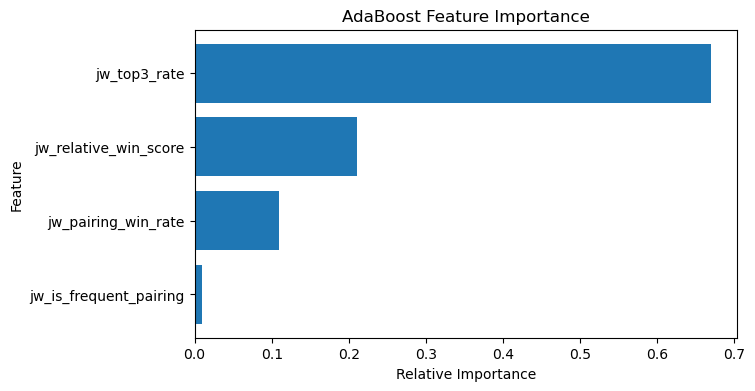

jw_top3_rate: 0.670
jw_relative_win_score: 0.210
jw_pairing_win_rate: 0.110
jw_is_frequent_pairing: 0.010


In [111]:
# feature importance
importances = jw_adaboost.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns[indices]

plt.figure(figsize=(7,4))
plt.barh(feature_names[::-1], importances[indices][::-1])
plt.title("AdaBoost Feature Importance")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.show()

for name, val in zip(feature_names, importances[indices]):
    print(f"{name}: {val:.3f}")

In [ ]:
# next steps - summarise the above findings, and tune the model further 